Optimización aleatoria sala 2

In [1]:
import os
import time
os.chdir('..')

In [2]:
from room.geometry_generator import calculation_of_geometry
from mesh.mesh_3D_complex import create_complex_mesh
from FEM.FEM_source import FEM_Source_Solver_Average
from aux.merit_figure import merit_magnitude_deviation, merit_spatial_deviation
from plots.graph_room_outline import plot_room_outline

import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Condiciones de la sala
Lx = 3       # Largo de la sala en X 
Ly = 4.2         # Largo de la sala en Y
Lz = 2.4       # Alto de la sala
Dx = 0.5       # Delta X
Dy = 0.8       # Delta Y
Dz = 0.2      # Delta Z

## Posiciones fuente y receptor (en metros)
source_position = (2, 3, 1.3)
receptor_position = (1.5, 2, 1.2)

In [4]:
# Parametros de control
N = 250        # Densidad de la grilla del generador de geometrías
M = 200        # Cantidad de salas a generar
n_walls = 2    # Número de cortes en las paredes
res_freq = 1

In [7]:
# Almacenar toda la data
start_time = time.time()
rooms = calculation_of_geometry(int(Lx * 100), int(Ly * 100), int(Dx * 100), int(Dy * 100), N, M, n_walls)
mesh = "room_mesh_complex"  # Crear malla con el script correspondiente
mesh1 = "room_mesh_complex1"  # Crear malla con el script correspondiente
mesh2 = "room_mesh_complex2"  # Crear malla con el script correspondiente
mesh3 = "room_mesh_complex3"  # Crear malla con el script correspondiente
mag_responses = []
merit_sv_values = []
merit_md_values = []

# Itera y almacena los valores para encontrar el mejor cuarto
for i in range(M):
    print("Vamos por el room: ", i)

    # Crea la malla de la geometría selecionada
    Z = (Lz - np.random.uniform(0, Dz))
    create_complex_mesh(rooms[i], Z, source_position, 80, mesh1)
    create_complex_mesh(rooms[i], Z, source_position, 140, mesh2)
    create_complex_mesh(rooms[i], Z, source_position, 200, mesh3)

    # Evalua la rta en frecuencia para esa sala
    f1 = np.arange(20, 80, res_freq)
    res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

    f2 = np.arange(80, 140, res_freq)
    res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

    f3 = np.arange(140, 200, res_freq)
    res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

    res_tot = np.hstack([res1, res2, res3])
    res_tot_prom = np.sum(res_tot, axis=0) / 7

    # Calcula figuras de mérito
    sv_merit = merit_spatial_deviation(res_tot)
    md_merit = merit_magnitude_deviation(res_tot)
    
    merit_sv_values.append(sv_merit)
    merit_md_values.append(md_merit)
    mag_responses.append(res_tot_prom)
    print("Vamos por el room: ", i)

f_tot =  np.hstack([f1, f2, f3])
merit_sv_values = np.array(merit_sv_values)
merit_md_values = np.array(merit_md_values)
merit_general = merit_md_values + merit_sv_values

idx_best_room = np.argmin(merit_general)
idx_worst_room = np.argmax(merit_general)

best_room_mag = mag_responses[idx_best_room]
worst_room_mag = mag_responses[idx_worst_room]
random_room_mag = mag_responses[np.random.randint(0, M - 1)]


Vamos por el room:  0
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 738 nodes
Info    : 3961 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 2998 nodes
Info    : 17390 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entities
Info    : 5972 nodes
Info    : 34993 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Vamos por el room:  0
Vamos por el room:  1
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 687 nodes
Info    : 3608 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 2887 nodes
Info    : 16575 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.ms

In [8]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 12.486328557109406 | Con SV: 2.6205846674338553 | Con MD: 9.865743889675551
............................
El peor valor de mérito es: 22.53578172473424 | Con SV: 5.213630483668918 | Con MD: 17.32215124106532
............................
El valor de mértio promedio es:  18.182105926833977
............................
El tiempo de ejecución en minutos fue de:  79.72513309717178


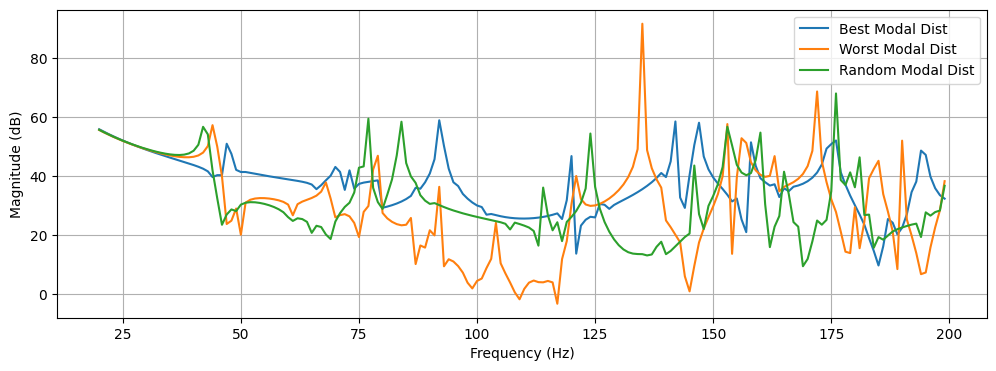

In [10]:
plt.figure("Resultado magnitud", figsize=(12, 4))
plt.plot(f_tot, best_room_mag, label= "Best Modal Dist")
plt.plot(f_tot, worst_room_mag, label= "Worst Modal Dist")
plt.plot(f_tot, random_room_mag, label= "Random Modal Dist")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

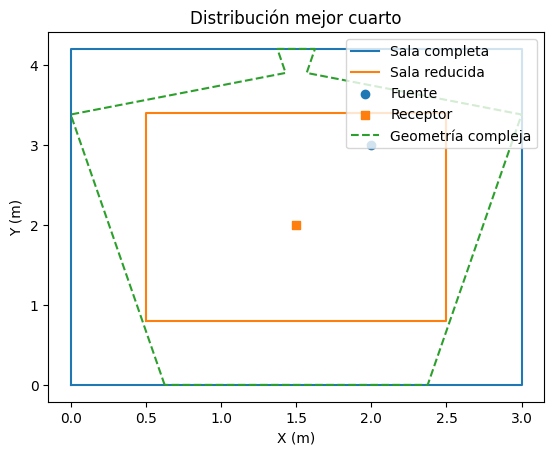

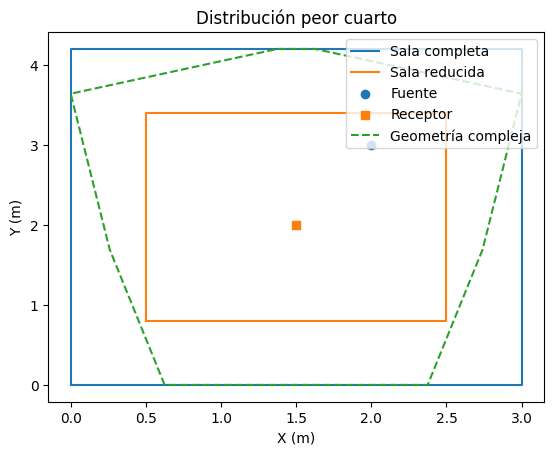

La mejor sala es:  [[0.625 0.   ]
 [0.    3.38 ]
 [1.43  3.9  ]
 [1.375 4.2  ]
 [1.625 4.2  ]
 [1.57  3.9  ]
 [3.    3.38 ]
 [2.375 0.   ]]
............................
La peor sala es:  [[0.625 0.   ]
 [0.26  1.69 ]
 [0.    3.64 ]
 [1.375 4.2  ]
 [1.625 4.2  ]
 [3.    3.64 ]
 [2.74  1.69 ]
 [2.375 0.   ]]


In [12]:
plot_room_outline(Lx * 100, Ly * 100, Dx * 100, Dy * 100, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx * 100, Ly * 100, Dx * 100, Dy * 100, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])